# Colima Seperate GS Inversion

In [3]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re

In [4]:
filename = "./data/colima/colima_real_data.csv"

raw_df = pd.read_csv(filename)

phi_labels = [
    "[-5,-4)",
    "[-4,-3)" ,
    "[-3,-2)",
    "[-2,-1)",
    "[-1,0)",
    "[0,1)",
    "[1,2)",
    "[2,3)",
    "[3,4)"
]

ventx = 645110
venty = 2158088

raw_df["Easting"] = raw_df["Easting"] - ventx
raw_df["Northing"] = raw_df["Northing"] - venty

for phi in phi_labels:
    raw_df[phi] = (raw_df[phi].values)*100
    
raw_df["radius"] = np.sqrt(raw_df["Easting"]**2 + raw_df["Northing"]**2)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
0,VF95-06a,3133,9522,417.20,40,0.0,11.0,21.0,22.0,23.0,17.0,4.0,0.0,0.0,10024.179418
1,VF95-08a,1907,8096,312.90,30,1.0,13.0,19.0,24.0,25.0,16.0,3.0,0.0,0.0,8317.563646
2,VF97-20Q,5500,8723,208.60,20,2.0,7.0,14.0,21.0,26.0,21.0,6.0,1.0,1.0,10312.164128
3,VF98-01a3,2665,9054,239.89,23,4.0,13.0,18.0,21.0,23.0,15.0,3.0,0.0,0.0,9438.068711
4,VF98-02a,1154,7735,156.45,15,1.0,12.0,19.0,23.0,24.0,17.0,3.0,0.0,0.0,7820.610015


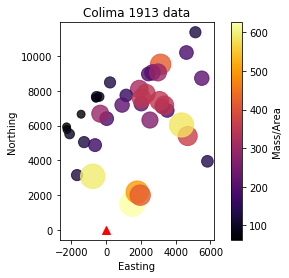

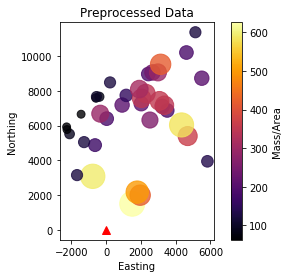

In [5]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()
obs_df["radius"] = np.sqrt(obs_df["Easting"]**2 + obs_df["Northing"]**2)

obs_df = obs_df.sort_values(by=['radius'])\

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

# Uncomment to drop proximal points
# obs_df = obs_df[obs_df["radius"]>3500]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [6]:
grid = obs_df[["Easting", "Northing"]].copy()
grid["Elevation"] = np.zeros(len(grid))
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

# Order of these 3 commands matter
t2_df["radius"] = np.sqrt(t2_df["Easting"]**2 + t2_df["Northing"]**2)
t2_df = t2_df.sort_values(by=['radius'])
t2_df["Residual"] = t2_df["MassArea"]/obs_df["MassArea"]*100

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,833.032,17.3819,20.9560,20.9332,17.7376,12.6550,6.92374,2.59392,0.692536,0.126138,2124.861643,133.114733
18,1957,1997,0,695.129,17.3999,21.2760,20.9644,17.4749,12.3856,6.83364,2.73539,0.781439,0.148918,2796.043276,166.617689
17,1787,2173,0,694.558,17.5614,21.4823,21.1019,17.4671,12.2469,6.65295,2.61205,0.736269,0.139112,2813.413940,138.734020
37,-770,3082,0,227.391,14.1129,18.5440,20.7423,19.3846,14.6875,8.27902,3.20274,0.881546,0.165408,3176.731654,38.248474
31,-1673,3152,0,100.136,11.3118,15.5037,19.2828,20.3236,17.0715,10.53570,4.42227,1.293020,0.255589,3568.477687,80.006392


In [8]:
config = {}
with open("data/colima/colima_config.txt") as f:
    for line in f:
        line = line.strip()
        if not line=="" and not line.startswith("#"):
            (key, val) = line.split()
            config[str(key)] = float(val)

config["COL_STEPS"] = int(config["COL_STEPS"])
config["PART_STEPS"] = int(config["PART_STEPS"])

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}



# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 645110.0,
 'VENT_NORTHING': 2158088.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,1024.0,"[-5,-4)",-5.0,0.068338,-4.0
1,-3.5,1024.0,"[-4,-3)",-4.0,0.109203,-3.0
2,-2.5,1024.0,"[-3,-2)",-3.0,0.146694,-2.0
3,-1.5,1024.0,"[-2,-1)",-2.0,0.165650,-1.0
4,-0.5,1024.0,"[-1,0)",-1.0,0.157243,0.0


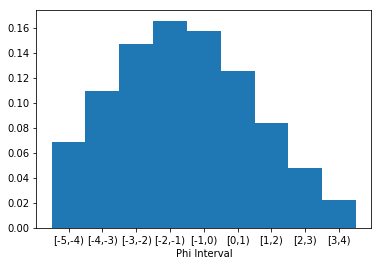

In [9]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps).head())



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [10]:

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)

forward_df = gaussian_stack_forward(
        config, globs, grid, int(config["COL_STEPS"]), 0, 
        config["PLUME_HEIGHT"], phi_steps, q_dist, config["ERUPTION_MASS"], (u,v)
    )

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"]/obs_df["MassArea"]*100
display(forward_df.head())

,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,14.662719,21.477998,23.539136,19.738045,12.911090,6.004510,1.483327,0.176485,0.006689,1198.607874,2124.861643,287.298148
1,1997,1957,12.230719,20.077097,23.726699,20.663027,13.960236,6.966140,2.072407,0.291357,0.012318,1005.835755,2796.043276,321.455978
2,2173,1787,12.123985,20.006264,23.736202,20.718095,14.012231,7.001938,2.093069,0.295676,0.012540,1024.563441,2813.413940,491.161765
3,3082,-770,12.554313,20.438257,23.932389,20.448488,13.450774,6.659616,2.162336,0.338322,0.015505,404.939158,3176.731654,168.802017
4,3152,-1673,12.594545,20.611603,24.181124,20.493127,13.155693,6.344995,2.210467,0.388875,0.019571,193.246416,3568.477687,123.519601


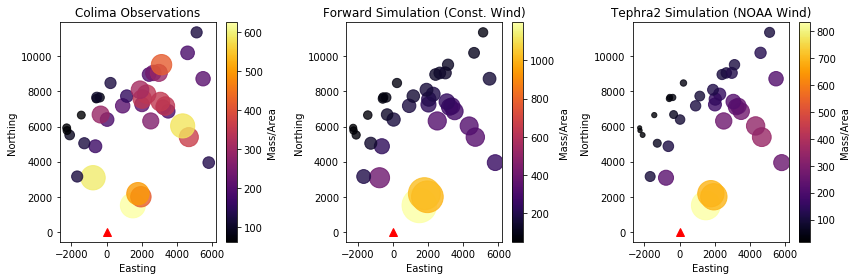

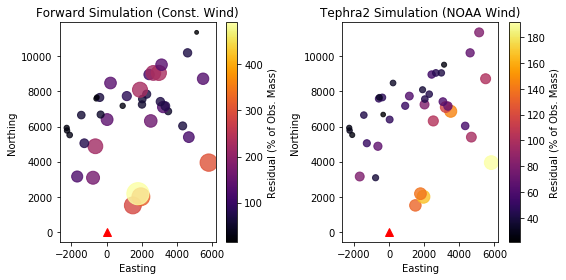

In [17]:
fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[2])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=(
        8,4), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=False, values="Residual",
            title="Forward Simulation (Const. Wind)", cbar_label="Residual (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_df, vent=(0,0), log=False, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Residual (% of Obs. Mass)", ax=axs[1])


plt.tight_layout()
plt.show()

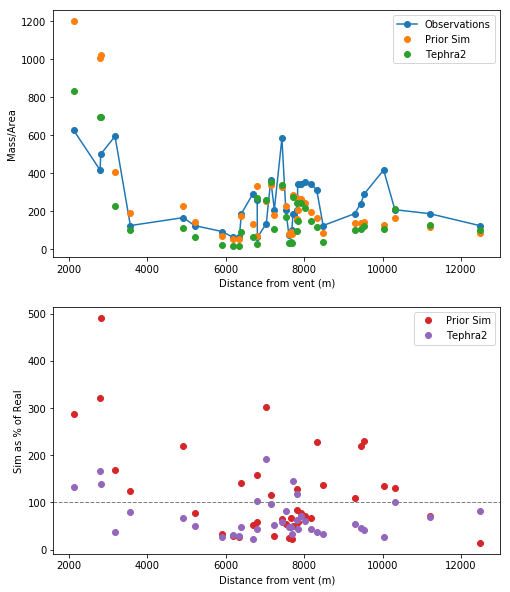

In [18]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()


axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Prior Sim")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C2o', label="Tephra2")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C3o', label="Prior Sim")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C4o', label="Tephra2")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========[-5,-4)========
a* = 14.23744	b* = 15.10182            	h0* = -1.52718	h1* = 1.49994
a = 1524899.42161	b = 3619415.71858	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 65
SSE: 2094.829498485259


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:306: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


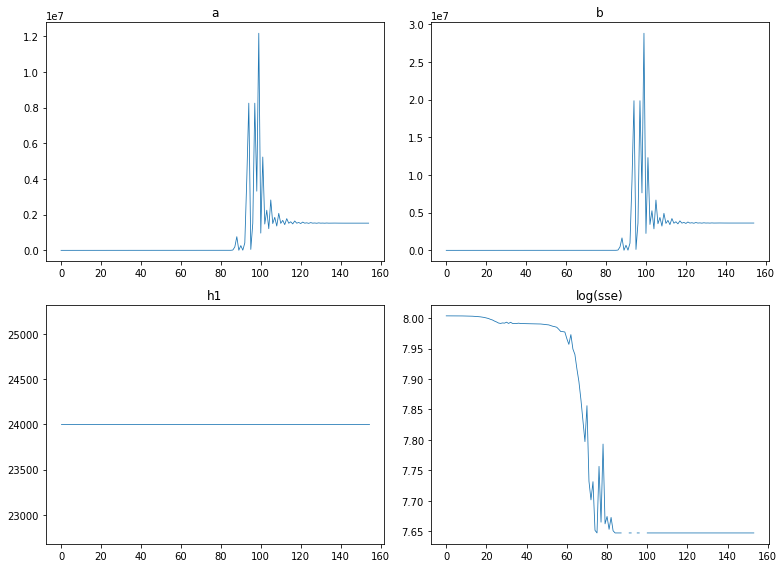

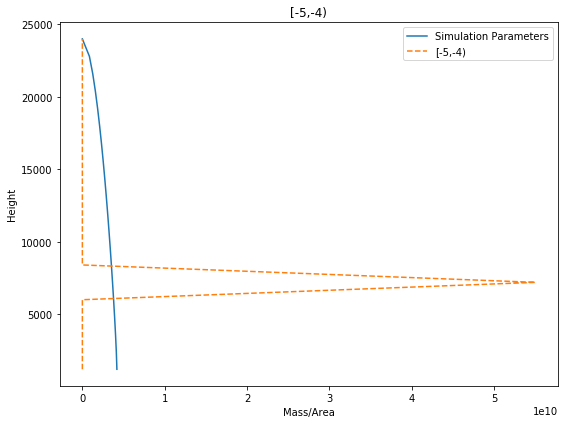

========[-4,-3)========
a* = 13.71857	b* = 15.08381            	h0* = -1.52718	h1* = 1.49994
a = 907609.90393	b = 3554819.91753	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 80
SSE: 1651.1103137128387


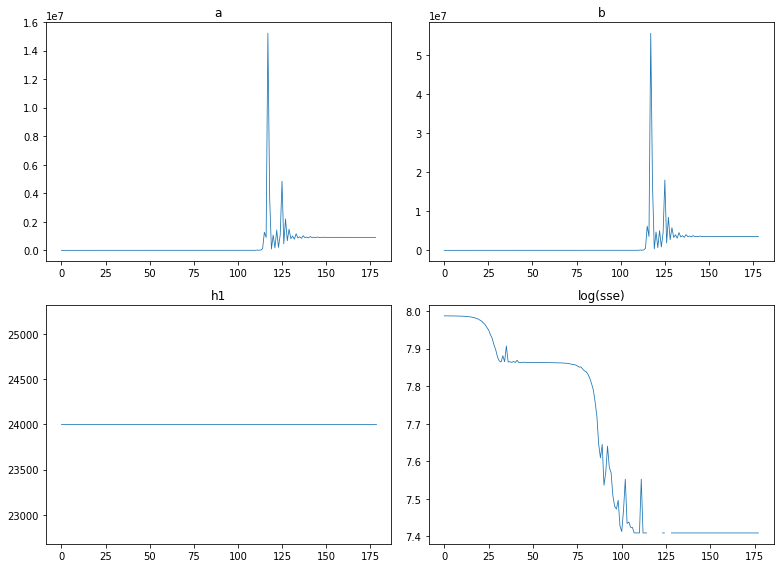

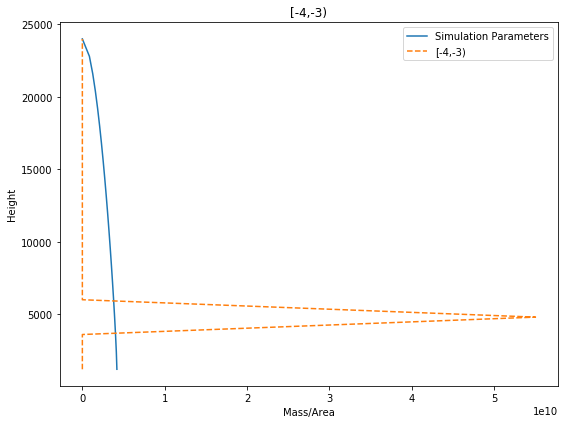

========[-3,-2)========
a* = 12.03850	b* = 13.67768            	h0* = -1.52718	h1* = 1.49994
a = 169144.01890	b = 871248.14057	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 94
SSE: 1090.6720841977722


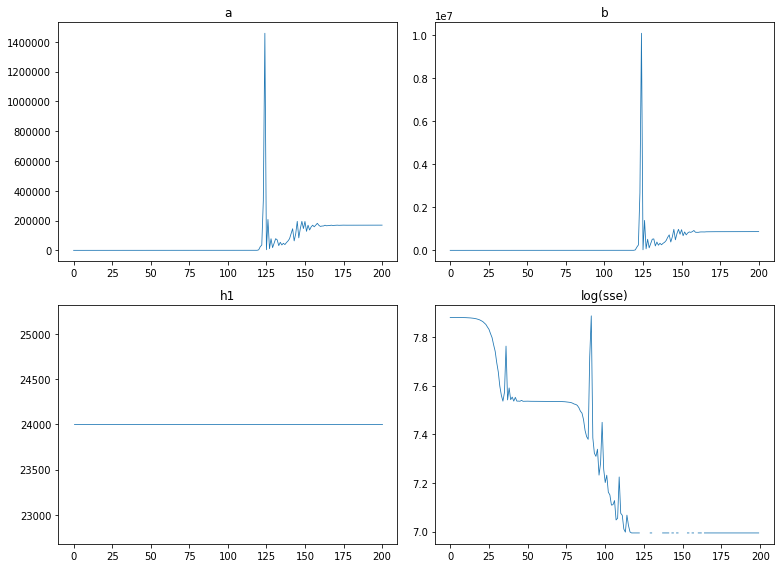

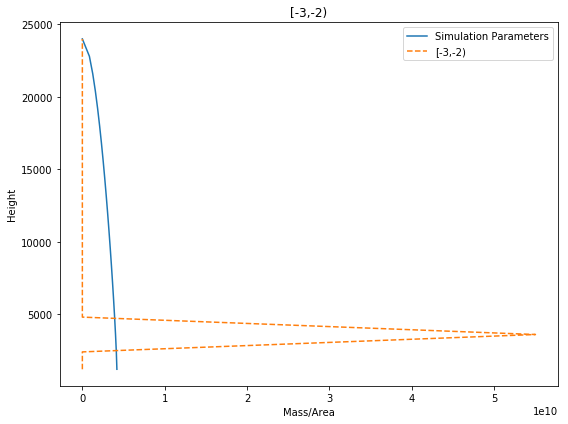

========[-2,-1)========
a* = 12.43508	b* = 14.59952            	h0* = -1.52718	h1* = 1.49994
a = 251470.07075	b = 2190240.55322	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 92
SSE: 848.8152491495542


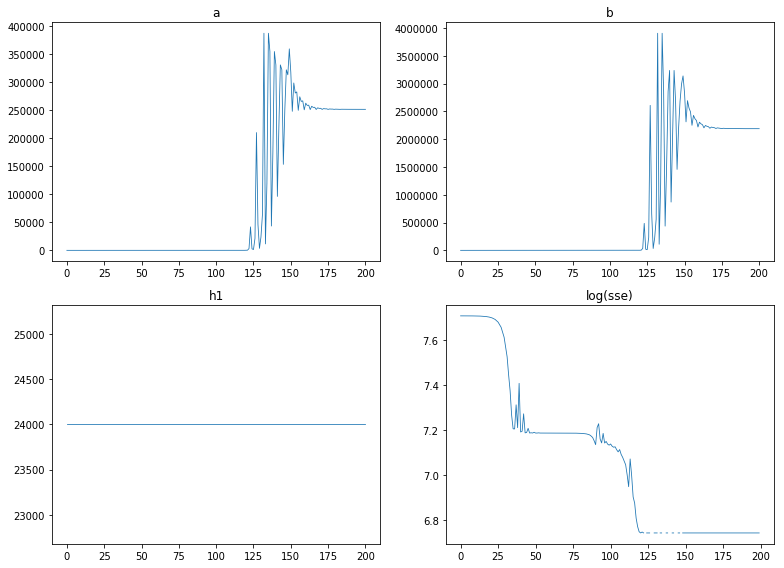

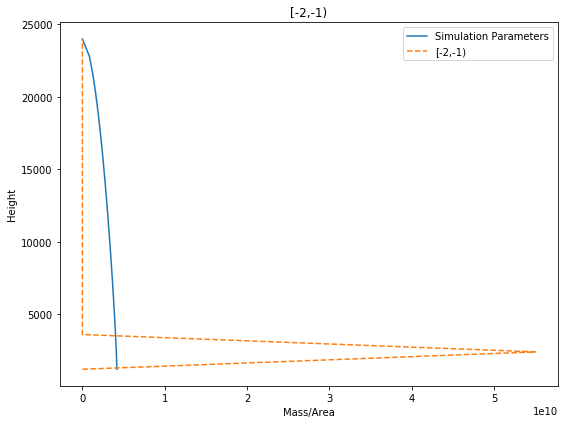

========[-1,0)========
a* = 12.97714	b* = 15.20343            	h0* = -1.52718	h1* = 1.49994
a = 432413.75802	b = 4006503.74165	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 112
SSE: 724.2139777208796


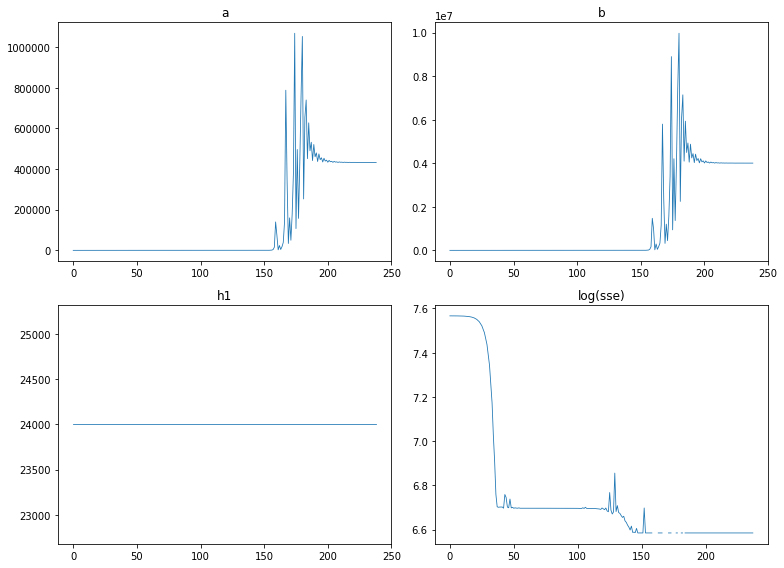

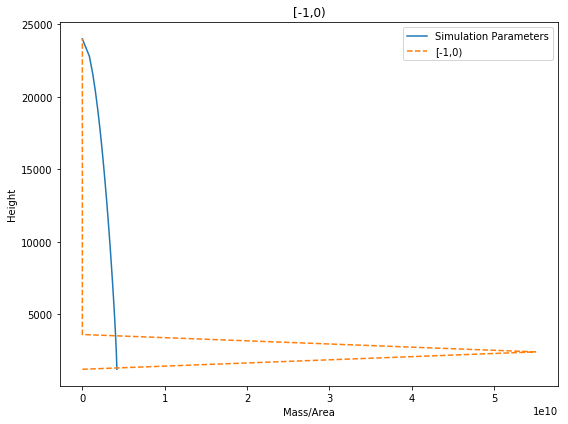

========[0,1)========
a* = 11.71736	b* = 14.72704            	h0* = -1.52718	h1* = 1.49994
a = 122683.87371	b = 2488120.68997	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 85
SSE: 285.8413861658147


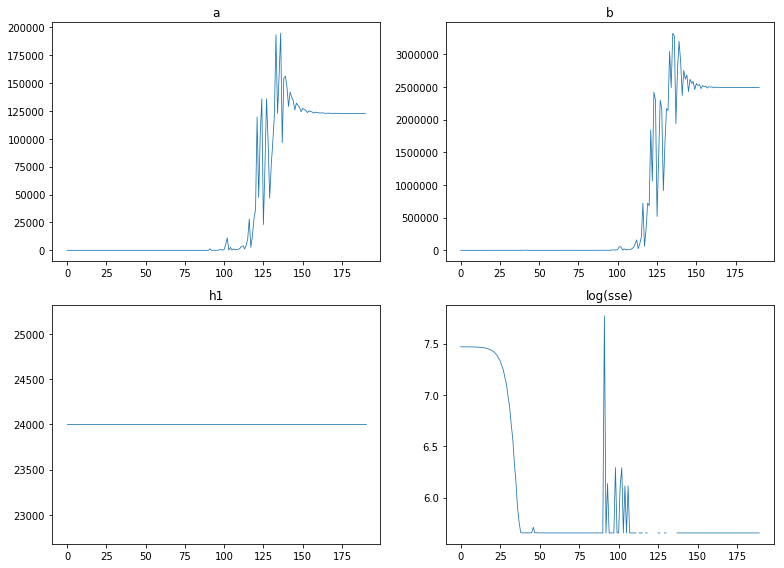

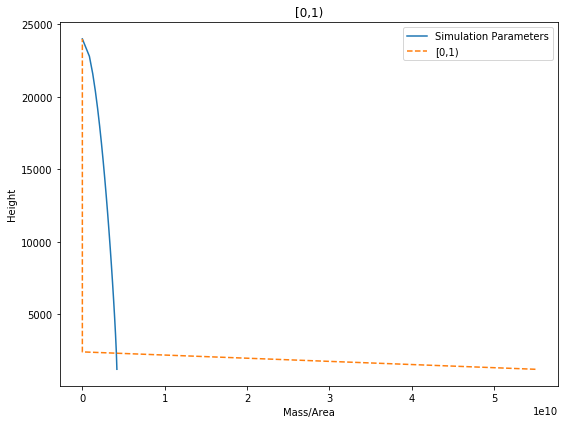

========[1,2)========
a* = 12.38743	b* = 14.63615            	h0* = -1.52718	h1* = 1.49994
a = 239769.77129	b = 2271943.32898	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 107
SSE: 95.1014438038074


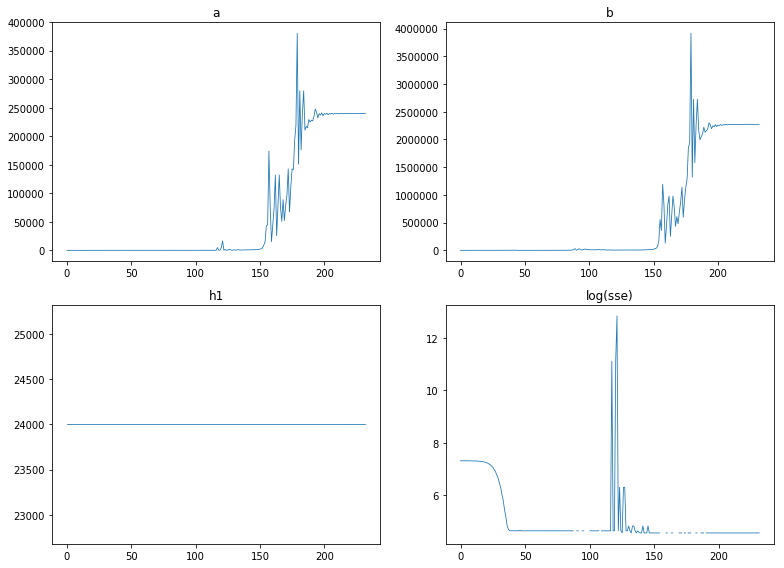

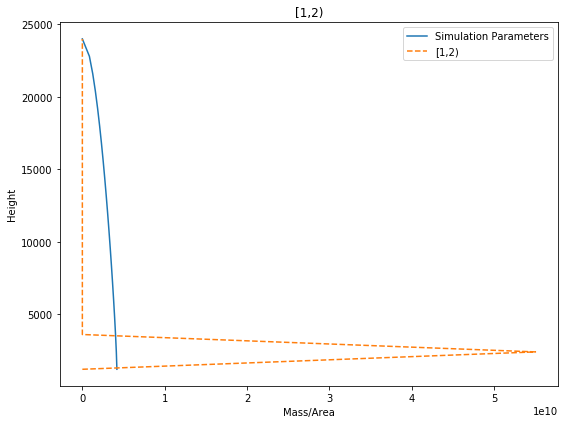

========[2,3)========
a* = 12.64010	b* = 15.63587            	h0* = -1.52718	h1* = 1.49994
a = 308692.03294	b = 6174076.47843	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 85
SSE: 22.480565516391774


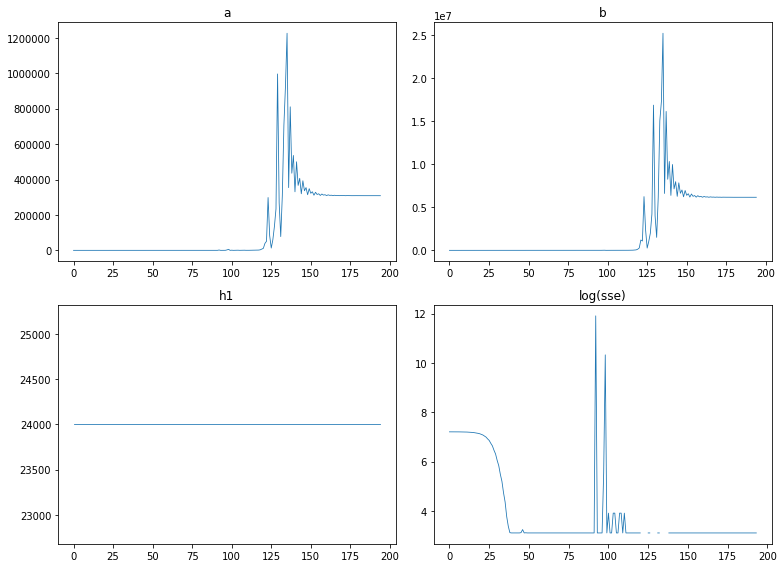

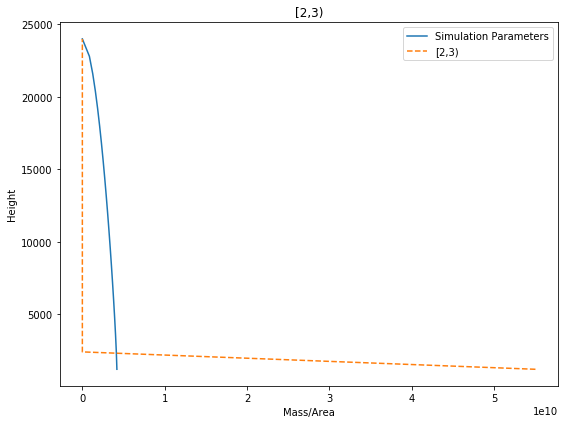

========[3,4)========
a* = 12.98273	b* = 15.95375            	h0* = -1.52718	h1* = 1.49994
a = 434839.61368	b = 8484494.89723	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 80
SSE: 7.000456030575933


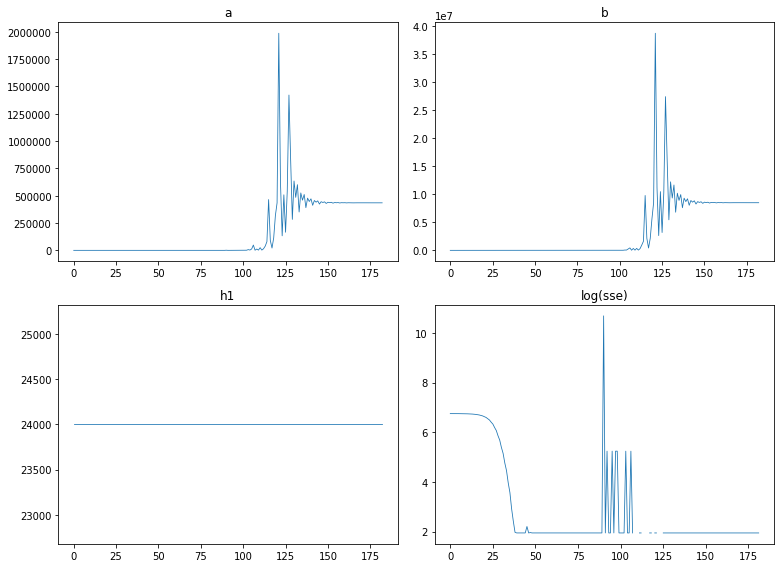

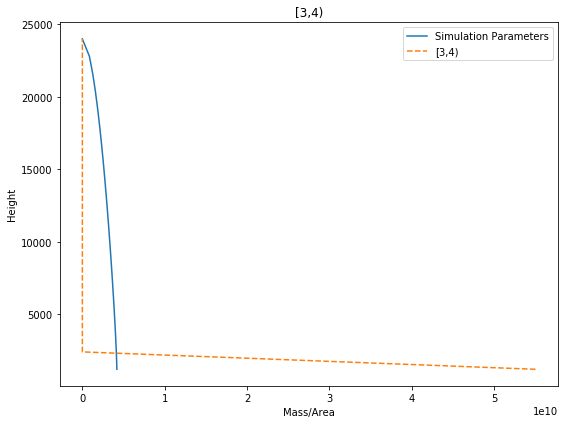

In [37]:
df = forward_df


priors_vals = {
    "a": 2,
    "b": 2,
    "h0": 0.01,
    "h1": 24000
}

invert_params = {
        "a" : True,
        "b" : True,
        "h0" : False,
        "h1" : False
    }

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    print("========%s========"%phi_step["interval"])
    out = gaussian_stack_inversion(config, 
                              globs, df, 
                              len(df), 
                              20, 0, 
                              config["PLUME_HEIGHT"], 
                              mass_in_phi,
                              (u,v),
                              [phi_step],
                              invert_params=invert_params,
                              priors = priors_vals, 
                              column_cap=H)
    inversion_table, _, _, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
#     display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,3], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_dist = beta(config["ALPHA"],config["BETA"])

    q_mass = mass_dist_in_plume(q_dist, 0, 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"], 
                                config["ERUPTION_MASS"])

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
    
    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()

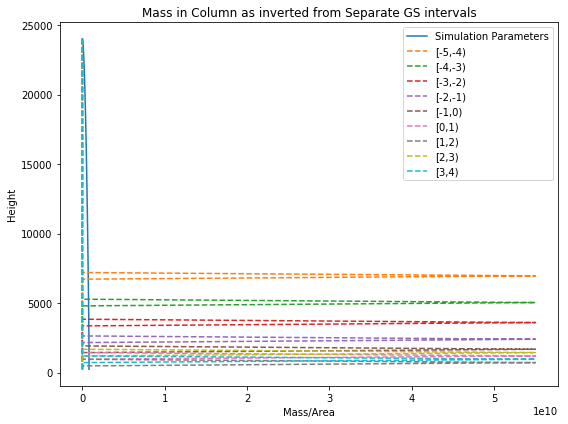

In [36]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(q_dist, 0, 
                            config["PLUME_HEIGHT"], 
                            inversion_table["Height"], 
                            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for phi_step, mass in zip(phi_steps, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=phi_step["interval"])
ax1.legend()
ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()